# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
feat_info.head()

attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]

In [4]:
azdias.describe().transpose().head()

count      mean       std  min  25%  50%  75%  max
AGER_TYP              891221.0 -0.358435  1.198724 -1.0 -1.0 -1.0 -1.0  3.0
ALTERSKATEGORIE_GROB  891221.0  2.777398  1.068775  1.0  2.0  3.0  4.0  9.0
ANREDE_KZ             891221.0  1.522098  0.499512  1.0  1.0  2.0  2.0  2.0
CJT_GESAMTTYP         886367.0  3.632838  1.595021  1.0  2.0  4.0  5.0  6.0
FINANZ_MINIMALIST     891221.0  3.074528  1.321055  1.0  2.0  3.0  4.0  5.0

In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
azdias.shape

(891221, 85)

In [7]:
#Check missingness
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [8]:
feat_info.head(5)

attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
print('Number of missing values before preprocessing',azdias.isnull().sum().sum())

Number of missing values before preprocessing 4896838


In [10]:
# Identify missing or unknown data values and convert them to NaNs.

def missingness(missing_or_unknown):
    new_list=list()
    for values in missing_or_unknown:
        new_list.append(values[1:-1].split(','))
    return new_list

missing_values = missingness(feat_info['missing_or_unknown'])

for attribute, missing_values_list in zip(feat_info["attribute"],missing_values):
    if missing_values_list[0] != '':
        for missing_value in missing_values_list:
            #check if the missing value is number (negative or positive numbers)
            if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                missing_value = int(missing_value)
            
            azdias.loc[azdias[attribute] == missing_value, attribute] = np.nan

In [11]:
print('Number of missing values after preprocessing',azdias.isnull().sum().sum()) 

Number of missing values after preprocessing 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
percentage_missing_col =(azdias.isnull().sum()/len(azdias))*100
percentage_missing_col.sort_values(ascending=False)

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

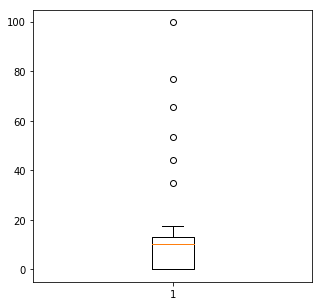

In [13]:
# creating a box plot to indicate the outliers
fig = plt.figure(figsize =(5, 5))
plt.boxplot(percentage_missing_col)
plt.show()

In [14]:
#Total number of columns with missing values
len(percentage_missing_col[percentage_missing_col > 0])

61

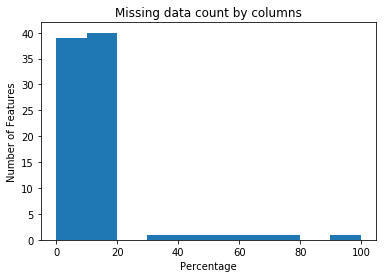

In [15]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(percentage_missing_col)
plt.xlabel('Percentage')
plt.ylabel('Number of Features')
plt.title('Missing data count by columns');


In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#Drop columns with more than 20% missingness since they are too many and bring no value, and in this case we consider them outliers

top_20_missing = percentage_missing_col[percentage_missing_col > 20]

print('We drop these columns with more than 20% missingness: {}'.format(top_20_missing))



We drop these columns with more than 20% missingness: AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64


In [17]:
azdias = azdias.drop(top_20_missing.index.tolist(), axis=1)

#### Discussion 1.1.2: Assess Missing Data in Each Column
Some columns have very high number of missing values, ranging from 40%  to 99% of missingness. DEpending on the threshold we chose which is 20% in this case, features above this threshold will be dropped since trying to impute such high amounts of missing values will result in misleading models. These columns are as below TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

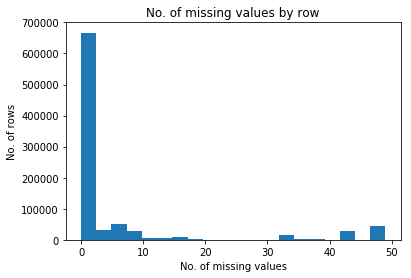

In [18]:
# How much data is missing in each row of the dataset?
missing_data_rows = azdias.isnull().sum(axis=1)
missing_data_rows

plt.hist(missing_data_rows, bins=20)
plt.xlabel('No. of missing values')
plt.ylabel('No. of rows')
plt.title('No. of missing values by row');


In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#Going by 20% threshold, 
missing_above_20 = azdias[missing_data_rows>=20]
missing_below_20 = azdias[missing_data_rows<20]

In [20]:
print(missing_above_20.shape)
print(missing_below_20.shape)

(94144, 79)
(797077, 79)


In [21]:
missing_below_20.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
1                   1.0        2.0            5.0                1.0   
2                   3.0        2.0            3.0                1.0   
3                   4.0        2.0            2.0                4.0   
4                   3.0        1.0            5.0                4.0   
5                   1.0        2.0            2.0                3.0   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
1            5.0               2.0             5.0                    4.0   
2            4.0               1.0             2.0                    3.0   
3            2.0               5.0             2.0                    1.0   
4            3.0               4.0             1.0                    3.0   
5            1.0               5.0             2.0                    2.0   

   FINANZ_HAUSBAUER  FINANZTYP    ...     PLZ8_ANTG1  PLZ8_ANTG2  PLZ8_ANTG3  \
1               5.0        1.0    ...            2.0         3.0         2.0   
2               5.0        1.0    ...            3.0         3.0         1.0   
3               2.0        6.0    ...            2.0         2.0         2.0   
4               2.0        5.0    ...            2.0         4.0         2.0   
5               5.0        2.0    ...            2.0         3.0         1.0   

   PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  ORTSGR_KLS9  RELAT_AB  
1         1.0          1.0       5.0       4.0     3.0          5.0       4.0  
2         0.0          1.0       4.0       4.0     3.0          5.0       2.0  
3         0.0          1.0       3.0       4.0     2.0          3.0       3.0  
4         1.0          2.0       3.0       3.0     4.0          6.0       5.0  
5         1.0          1.0       5.0       5.0     2.0          3.0       3.0  

[5 rows x 79 columns]

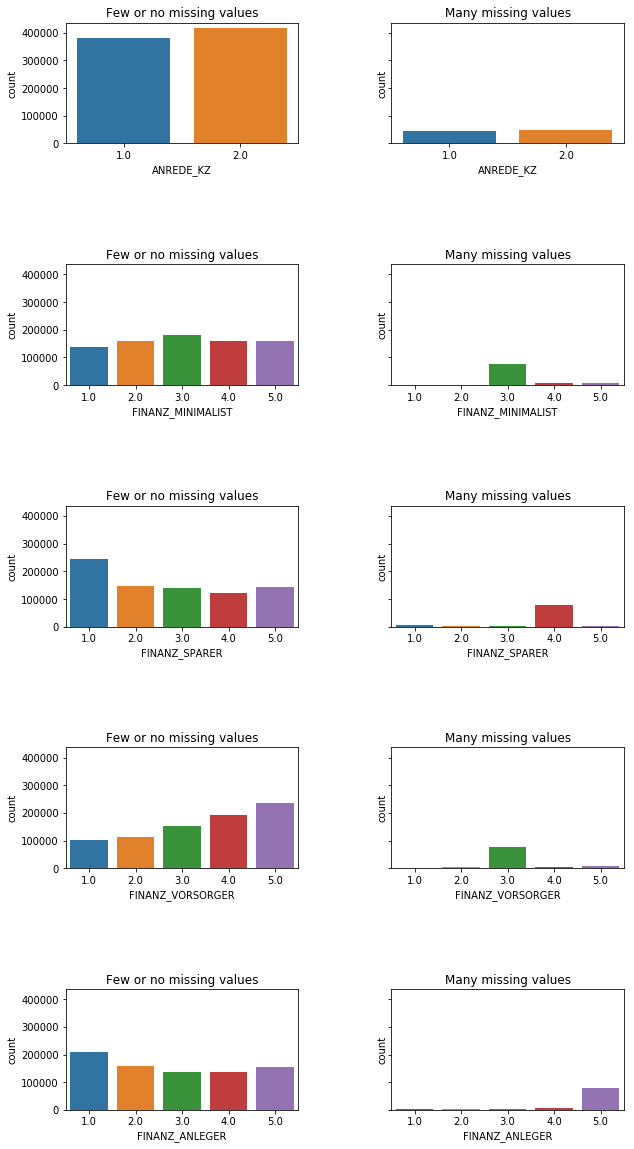

In [22]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

no_missing_col = percentage_missing_col[percentage_missing_col == 0].index.tolist()
compare_cols = no_missing_col[:5]

figure, axs = plt.subplots(nrows=len(compare_cols), ncols=2, figsize = (10,20), sharey=True)
figure.subplots_adjust(hspace = 1, wspace=.4)
for i in range(len(compare_cols)):
    sns.countplot(missing_below_20[compare_cols[i]], ax=axs[i][0])
    axs[i][0].set_title('Few or no missing values')
    sns.countplot(missing_above_20[compare_cols[i]], ax=axs[i][1])
    axs[i][1].set_title('Many missing values')

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

The data with lots of missing values are in most cases fewer than data with fewer missing values. The distributions in the sets with more vs few missing values are also very different.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
# How many features are there of each data type?
features = azdias.keys().tolist()
features = feat_info[feat_info['attribute'].isin(missing_below_20)] #extracting the needed features only
features['type'].value_counts()


ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

In [24]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_features = features[features['type']=='categorical']['attribute']
#cat_cols = cat_features.columns

In [25]:
# Re-encode categorical variable(s) to be kept in the analysis.
binary = []
multi= []

for i in cat_features:
    if (missing_below_20[i].nunique()==2):
        binary.append(i)
    else:
        multi.append(i)

In [26]:
binary

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [27]:
multi

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [28]:
#drop multi features
missing_below_20 = missing_below_20.drop(multi, axis = 1)

In [29]:
missing_below_20['OST_WEST_KZ'] = missing_below_20['OST_WEST_KZ'].replace({'W': 0, 'O': 1})

#### Discussion 1.2.1: Re-Encode Categorical Features
There are 5 binary categorical features which we will carry on with in our analysis

For multi_level categorical columns, we chose to drop them for simplicity 

In [30]:
mixed_features = features[features['type']=='mixed']['attribute']
mixed_features

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [31]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
#LETS BREAKDOWN THE FEATURES UNDER "PRAEGENDE_JUGENDJAHRE" BASING ON MOVEMENT AND THE YEARS
#mapping the values in "PRAEGENDE_JUGENDJAHRE" by the decade
decade = {1:40, 2:40, 3:50,4:50, 5:60, 6:60,7:60,8:70,9:70,
          10:80, 11:80,12:80,13:80,14:90,15:90, np.nan:np.nan}
 

#Mapping again by movement
movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1,
           10:0, 11:1, 12:0, 13:1,14:0, 15:1, np.nan:np.nan}

missing_below_20['DECADE'] = missing_below_20['PRAEGENDE_JUGENDJAHRE']
missing_below_20['DECADE'].replace(decade, inplace = True)

missing_below_20['MOVEMENT'] = missing_below_20['PRAEGENDE_JUGENDJAHRE']
missing_below_20['MOVEMENT'].replace(movement, inplace = True)


# Investigate "CAMEO_INTL_2015" and engineer two new variables.

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [32]:
#Dictionary the wealth status
wealth = {11:1,12:1,13:1,14:1, 15:1,
         21:2,22:2,23:2,24:2,25:2,
         31:3,32:3,33:3,34:3,35:3,
         41:4,42:4,43:4,44:4,45:4,
         51:5,52:5,53:5,54:5,55:5}

#Dictionary of life stage
 
ls = {11:1,12:2,13:3,14:4, 15:5,
      21:1,22:2,23:3,24:4,25:5,
      31:1,32:2,33:3,34:4,35:5,
      41:1,42:2,43:3,44:4,45:5,
      51:1,52:2,53:3,54:4,55:5}

missing_below_20['WEALTH'] = missing_below_20['CAMEO_INTL_2015']
missing_below_20['WEALTH'].replace(wealth, inplace = True)

missing_below_20['LIFE_STAGE'] = missing_below_20['CAMEO_INTL_2015']
missing_below_20['LIFE_STAGE'].replace(ls, inplace = True)


#### Discussion 1.2.2: Engineer Mixed-Type Features

We have brocken down the mixed features under 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' columns according to year / movement and wealth / life style respectively. Their initial coumns then become irrelevant to our analysis since we have extracted the needed info from them and so they are dropped. 

We also dropped other features with mixed categories from our dataframe 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [33]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

#lets us drop the broken down mixed columns
missing_below_20 = missing_below_20.drop(mixed_features, axis=1)           
missing_below_20.head()    

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
3                   4.0        2.0                4.0            2.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   

   GREEN_AVANTGARDE  HEALTH_TYP     ...      PLZ8_ANTG4  PLZ8_HHZ  PLZ8_GBZ  \
1                 0         3.0     ...             1.0       5.0       4.0   
2                 1         3.0     ...             0.0       4.0       4.0   
3                 0         2.0     ...             0.0       3.0       4.0   
4                 0         3.0     ...             1.0       3.0       3.0   
5                 0         3.0     ...             1.0       5.0       5.0   

   ARBEIT  ORTSGR_KLS9  RELAT_AB  DECADE  MOVEMENT  WEALTH  LIFE_STAGE  
1     3.0          5.0       4.0    90.0       0.0      51          51  
2     3.0          5.0       2.0    90.0       1.0      24          24  
3     2.0          3.0       3.0    70.0       0.0      12          12  
4     4.0          6.0       5.0    70.0       0.0      43          43  
5     2.0          3.0       3.0    50.0       0.0      54          54  

[5 rows x 64 columns]

In [34]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

missing_below_20 = missing_below_20.fillna(missing_below_20.mode().iloc[0])

In [35]:
missing_below_20.isnull().sum().sum()

0

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [36]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # Identify missing or unknown data values and convert them to NaNs.
    missing_values = missingness(feat_info["missing_or_unknown"])
    
    for attribute,missing_values_list in zip(feat_info["attribute"],missing_values):
        if missing_values_list[0] != "": 
            for missing_value in missing_values_list:
                #check if the missing value is number (negative or positive numbers)
                if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                    missing_value = int(missing_value)

                df.loc[df[attribute] == missing_value, attribute] = np.nan

    # remove selected columns and rows, ...
    top_20_col=['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP','TITEL_KZ']
    df.drop(columns = top_20_col, axis='columns', inplace = True)

    missing_data_rows = df.isnull().sum(axis=1)
    missing_below_20 = df[missing_data_rows < 20]
    missing_above_20 = df[missing_data_rows >= 20]
    missing_below_20 = missing_below_20.fillna(missing_below_20.mode().iloc[0])
    
    # select, re-encode, and engineer column values.
    features = azdias.keys().tolist()
    features = feat_info[feat_info['attribute'].isin(missing_below_20)] #extracting the needed features only
    features['type'].value_counts()
    
    cat_features = features[features['type']=='categorical']
    
    binary = []
    multi = []
    for i in cat_features.attribute:
        if missing_below_20[i].nunique()==2:
            binary.append(i)
    else:
        multi.append(i)
    
    #drop multi columns
    missing_below_20 = missing_below_20.drop(multi, axis=1)    
        
    #Encoding the 'OST_WEST_KZ' column and onehotencode the multilevel columns
    missing_below_20['OST_WEST_KZ'].replace({'W':0, 'O': 1}, inplace = True)
    
      
    #Breaking down mixed columns
    #Mapping decade
    decade = {1:40, 2:40, 3:50,4:50, 5:60, 6:60,7:60,8:70,9:70,
          10:80, 11:80,12:80,13:80,14:90,15:90, np.nan:np.nan}
    
    #Mapping by movement
    movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1,
           10:0, 11:1, 12:0, 13:1,14:0, 15:1, np.nan:np.nan}
     
    missing_below_20['DECADE'] = missing_below_20['PRAEGENDE_JUGENDJAHRE']
    missing_below_20['DECADE'].replace(decade, inplace = True)

    missing_below_20['MOVEMENT'] = missing_below_20['PRAEGENDE_JUGENDJAHRE']
    missing_below_20['MOVEMENT'].replace(movement, inplace = True)

    
    #Dictionary the wealth status
    wealth = {11:1,12:1,13:1,14:1, 15:1,
         21:2,22:2,23:2,24:2,25:2,
         31:3,32:3,33:3,34:3,35:3,
         41:4,42:4,43:4,44:4,45:4,
         51:5,52:5,53:5,54:5,55:5}

    #Dictionary of life stage
 
    ls = {11:1,12:2,13:3,14:4, 15:5,
      21:1,22:2,23:3,24:4,25:5,
      31:1,32:2,33:3,34:4,35:5,
      41:1,42:2,43:3,44:4,45:5,
      51:1,52:2,53:3,54:4,55:5}
    
    missing_below_20['WEALTH'] = missing_below_20['CAMEO_INTL_2015']
    missing_below_20['WEALTH'].replace(wealth, inplace = True)

    missing_below_20['LIFE_STAGE'] = missing_below_20['CAMEO_INTL_2015']
    missing_below_20['LIFE_STAGE'].replace(ls, inplace = True)

                  
    #Drop all mixed columns
    missing_below_20=missing_below_20.drop(mixed_features, axis=1)                     
    
    
    # Return the cleaned dataframe.
    return missing_below_20
      

In [37]:
azdias_test_df = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
azdias_test_df.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

In [38]:
azdias_test_df = clean_data(azdias_test_df, feat_info)

azdias_test_df.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
1                   1.0        2.0            5.0                1.0   
2                   3.0        2.0            3.0                1.0   
3                   4.0        2.0            2.0                4.0   
4                   3.0        1.0            5.0                4.0   
5                   1.0        2.0            2.0                3.0   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
1            5.0               2.0             5.0                    4.0   
2            4.0               1.0             2.0                    3.0   
3            2.0               5.0             2.0                    1.0   
4            3.0               4.0             1.0                    3.0   
5            1.0               5.0             2.0                    2.0   

   FINANZ_HAUSBAUER  FINANZTYP     ...      PLZ8_ANTG4  PLZ8_HHZ  PLZ8_GBZ  \
1               5.0        1.0     ...             1.0       5.0       4.0   
2               5.0        1.0     ...             0.0       4.0       4.0   
3               2.0        6.0     ...             0.0       3.0       4.0   
4               2.0        5.0     ...             1.0       3.0       3.0   
5               5.0        2.0     ...             1.0       5.0       5.0   

   ARBEIT  ORTSGR_KLS9  RELAT_AB  DECADE  MOVEMENT  WEALTH  LIFE_STAGE  
1     3.0          5.0       4.0    90.0       0.0      51          51  
2     3.0          5.0       2.0    90.0       1.0      24          24  
3     2.0          3.0       3.0    70.0       0.0      12          12  
4     4.0          6.0       5.0    70.0       0.0      43          43  
5     2.0          3.0       3.0    50.0       0.0      54          54  

[5 rows x 76 columns]

In [39]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='most_frequent')
missing_below_20_imputes = pd.DataFrame(imputer.fit_transform(missing_below_20))
missing_below_20_imputes.columns = missing_below_20.columns                       
missing_below_20_imputes.index = missing_below_20.index

#matrix = imputer.fit_transform(missing_below_20)
#missing_below_20_imputes = pd.DataFrame(matrix, columns=missing_below_20.columns)

#missing_below_20_inputes = pd.DataFrame(imputer.fit_transform(missing_below_20), columns=missing_below_20.columns)

In [40]:
(missing_below_20.columns)^(missing_below_20_imputes.columns)


Index([], dtype='object')

In [41]:
missing_below_20_imputes.shape

(797077, 64)

In [42]:
print('Missing values in the dataset after filling nulls is: ',missing_below_20_imputes.isnull().sum().sum())

Missing values in the dataset after filling nulls is:  0


In [43]:
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin


class MyScaler(TransformerMixin, BaseEstimator):

    def fit(self, X, y=None):
        self.means_ = X.mean(axis=0)
        self.std_dev_ = X.std(axis=0)
        return self

    def transform(self, X, y=None):
        return (X - self.means_[:X.shape[1]]) / self.std_dev_[:X.shape[1]]
    
    def reverse(self,X):
        Y = np.zeros(shape=X.shape)
        for i in range(len(X[0])):
            for j in range(len(X)):
                Y[j][i] = X[j][i] * self.std[i] + self.mean[i]
        return Y

In [44]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = MyScaler()
scaled_feat =scaler.fit_transform(missing_below_20_imputes)

scaled_feat = pd.DataFrame(scaled_feat, columns = missing_below_20.columns)
scaled_feat.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1             -1.766172   0.958121          -1.494462       1.538138   
2              0.200733   0.958121          -1.494462       0.864752   
3              1.184186   0.958121           0.683285      -0.482020   
4              0.200733  -1.043709           0.683285       0.191366   
5             -1.766172   0.958121          -0.042631      -1.155406   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1         -1.040664        1.466400               0.959973          1.338531   
2         -1.766902       -0.570913               0.245237          1.338531   
3          1.138051       -0.570913              -1.184235         -0.792444   
4          0.411813       -1.250018               0.245237         -0.792444   
5          1.138051       -0.570913              -0.469499          1.338531   

   GREEN_AVANTGARDE  HEALTH_TYP     ...      PLZ8_ANTG4  PLZ8_HHZ  PLZ8_GBZ  \
1         -0.530654    1.010291     ...        0.441346  1.454539  0.573589   
2          1.884466    1.010291     ...       -0.935870  0.418828  0.573589   
3         -0.530654   -0.311792     ...       -0.935870 -0.616882  0.573589   
4         -0.530654    1.010291     ...        0.441346 -0.616882 -0.337417   
5         -0.530654    1.010291     ...        0.441346  1.454539  1.484595   

     ARBEIT  ORTSGR_KLS9  RELAT_AB    DECADE  MOVEMENT    WEALTH  LIFE_STAGE  
1 -0.171711    -0.127228  0.684697  1.098801 -0.530654  1.095810    1.095810  
2 -0.171711    -0.127228 -0.789243  1.098801  1.884466 -0.827059   -0.827059  
3 -1.173497    -0.997766 -0.052273 -0.267171 -0.530654 -1.681667   -1.681667  
4  0.830074     0.308041  1.421668 -0.267171 -0.530654  0.526071    0.526071  
5 -1.173497    -0.997766 -0.052273 -1.633143 -0.530654  1.309462    1.309462  

[5 rows x 64 columns]

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)


We have imputed missing values using the Imputer module from sklearn and standardized the data using the standard scaler

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [45]:
# Apply PCA to the data.

from sklearn.decomposition import PCA

pca = PCA()
pca.fit(scaled_feat)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

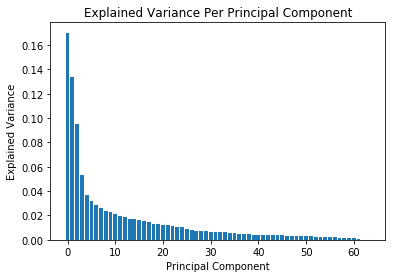

In [46]:
# Investigate the variance accounted for by each principal component.
num_components = np.arange(len(pca.explained_variance_ratio_))
values = pca.explained_variance_ratio_

plt.bar(num_components, values)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.title("Explained Variance Per Principal Component")
plt.show()


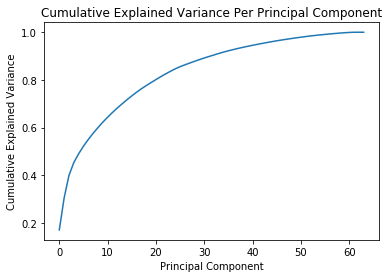

In [47]:
cum_vals = np.cumsum(values)

plt.plot(num_components, cum_vals)
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance Per Principal Component")
plt.show()

In [48]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_20 = PCA(n_components = 20)
PCA_data = pca_20.fit_transform(scaled_feat)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

We will retain 20 components because it achieves a fairly high explained variance of around 80%

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [49]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def PCA_weights(df, pca, n):
    weights_df = pd.DataFrame(pca.components_, columns = list(df.columns)).iloc[n]
    weights_df.sort_values(ascending = False, inplace = True)
    return weights_df

PCA_weights(scaled_feat, pca_20, 0)

PLZ8_ANTG3               0.227521
PLZ8_ANTG4               0.218445
WEALTH                   0.212054
LIFE_STAGE               0.212054
HH_EINKOMMEN_SCORE       0.206151
ORTSGR_KLS9              0.197217
EWDICHTE                 0.195189
FINANZ_HAUSBAUER         0.165581
KBA05_ANTG4              0.155907
PLZ8_ANTG2               0.155751
ARBEIT                   0.146407
KBA05_ANTG3              0.138416
ANZ_HAUSHALTE_AKTIV      0.138221
RELAT_AB                 0.137493
FINANZ_SPARER            0.134471
SEMIO_PFLICHT            0.103938
SEMIO_REL                0.100646
DECADE                   0.093483
SEMIO_RAT                0.085231
SEMIO_TRADV              0.076349
SEMIO_MAT                0.071014
SEMIO_FAM                0.069255
FINANZ_UNAUFFAELLIGER    0.063213
SEMIO_KULT               0.062010
REGIOTYP                 0.060752
FINANZ_ANLEGER           0.060466
OST_WEST_KZ              0.056553
W_KEIT_KIND_HH           0.043889
SEMIO_KAEM               0.043219
PLZ8_HHZ      

In [50]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

PCA_weights(scaled_feat, pca_20, 1)

ALTERSKATEGORIE_GROB     0.265881
FINANZ_VORSORGER         0.238375
SEMIO_ERL                0.234375
SEMIO_LUST               0.185786
RETOURTYP_BK_S           0.163112
SEMIO_KRIT               0.115132
W_KEIT_KIND_HH           0.111561
SEMIO_KAEM               0.110028
FINANZ_HAUSBAUER         0.107814
ANREDE_KZ                0.089724
EWDICHTE                 0.079524
PLZ8_ANTG3               0.078980
FINANZ_MINIMALIST        0.078249
ORTSGR_KLS9              0.078090
PLZ8_ANTG4               0.077210
WEALTH                   0.070892
LIFE_STAGE               0.070892
SEMIO_DOM                0.069742
WOHNDAUER_2008           0.063455
KBA05_ANTG4              0.061775
ARBEIT                   0.059850
RELAT_AB                 0.057707
PLZ8_ANTG2               0.055210
ANZ_HAUSHALTE_AKTIV      0.054699
HH_EINKOMMEN_SCORE       0.046789
KBA05_ANTG3              0.039234
VERS_TYP                 0.029184
ANZ_HH_TITEL             0.028589
OST_WEST_KZ              0.023303
PLZ8_HHZ      

In [51]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

PCA_weights(scaled_feat, pca_20, 2)

SEMIO_VERT               0.345652
SEMIO_SOZ                0.262192
SEMIO_FAM                0.249488
SEMIO_KULT               0.234973
FINANZ_MINIMALIST        0.156402
RETOURTYP_BK_S           0.107738
FINANZ_VORSORGER         0.101064
W_KEIT_KIND_HH           0.083799
ALTERSKATEGORIE_GROB     0.079039
SEMIO_REL                0.068742
SEMIO_LUST               0.063856
SEMIO_MAT                0.056053
GREEN_AVANTGARDE         0.047315
MOVEMENT                 0.047315
ORTSGR_KLS9              0.045800
PLZ8_ANTG4               0.045133
EWDICHTE                 0.044997
PLZ8_ANTG3               0.044546
ARBEIT                   0.035157
WOHNDAUER_2008           0.032802
RELAT_AB                 0.031992
LIFE_STAGE               0.030236
WEALTH                   0.030236
PLZ8_ANTG2               0.030160
KBA05_ANTG4              0.027236
ANZ_HAUSHALTE_AKTIV      0.024496
OST_WEST_KZ              0.015912
ANZ_HH_TITEL             0.012981
KBA05_ANTG3              0.010001
ANZ_TITEL     

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

The 1st principal component, show positive correlation for LP_STATUS_GROB_1.0, LIFE_STAGE, WEALTH is related to features such as family, social status, income and wealth with positive values for:
LP_STATUS_GROB_1.0 (Social status:low-income earners)
HH_EINKOMMEN_SCORE (Estimated household net income)
WEALTH(Households wealth)
PLZ8_ANTG3(Number of 6-10 family houses in the PLZ8 region)
Other factors like PLZ8_ANTG1, MOBI_REGIO, FINANZ_MINIMALIST which concern mobility and financial topology show the most negative correlation  

The 2nd principal component relates to financial and personality typology, age, and energy consumption with positive values on
ALTERSKATEGORIE_GROB(Estimated age based on given name analysis)
FINANZ_VORSORGER(Financial typology:be prepared)
ZABEOTYP_3.0(Energy consumption typology:fair supplied)
SEMIO_ERL(Personality typology:event-oriented) portray highest levels of positive correlation whereas DECADE(generation), FINANZ_SPARER(Financial, typology:money-saver)
FINANZ_UNAUFFAELLIGER(Financial typology:inconspicuous)
SEMIO_REL(Personality typology:religious)

The 3rd principal component concerns personality typology and gender features with positive correlation on ANREDE_KZ(Gender:femal,male)
SEMIO_VERT(Personality typology:dreamful)
SEMIO_FAM (Personality typology:family-minded)
SEMIO_SOZ (Personality typology:socially-minded)
and negative correlation on
SEMIO_KAEM (Personality typology:combative attitude)
SEMIO_DOM (Personality typology:dominant-minded)
SEMIO_KRIT (Personality typology:critical-minded)
SEMIO_ERL (Personality typology:event-oriented)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [52]:

# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    
from sklearn.cluster import KMeans

def kmeans_score(data, n_cluster):
    kmeans = KMeans(n_clusters = n_cluster)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

scores = []
ks = list(range(1, 15))
for k in ks:
    scores.append(kmeans_score(PCA_data, k))

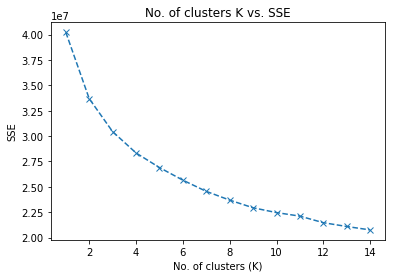

In [53]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(ks, scores, marker='x', linestyle='--')
plt.xlabel('No. of clusters (K)')
plt.ylabel('SSE')
plt.title("No. of clusters K vs. SSE")
plt.show()


In [54]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 6)
model = kmeans.fit(PCA_data)
pred_data = model.predict(PCA_data)


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)
The elbow is not very pronounced but we opt for 13 clusters is a logical choice as the adjuscent values are steadily decreasing thus not making great changes.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [55]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

customers_cleaned = clean_data(customers, feat_info)

customers_cleaned_imputed = pd.DataFrame(imputer.fit_transform(customers_cleaned))
customers_cleaned_imputed.columns = customers_cleaned.columns
customers_cleaned_imputed.index = customers_cleaned.index

In [56]:
customers_cleaned_imputed.isnull().sum().sum()

0

In [57]:
list(set(azdias_test_df)-set(customers_cleaned_imputed.columns))

[]

In [58]:
customers_cleaned_imputed=customers_cleaned_imputed.fillna(customers_cleaned_imputed.mode().iloc[0])


In [59]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# apply scaler
customers_cleaned_scaled = scaler.transform(customers_cleaned_imputed)
customers_cleaned_scaled=customers_cleaned_scaled.fillna(customers_cleaned_scaled.mode().iloc[0])
customers_cleaned_scaled = pd.DataFrame(customers_cleaned_scaled, columns = list(customers_cleaned_imputed))
# PCA transformation
customers_pca = pca_20.fit_transform(customers_cleaned_imputed)
# predict using Kmeans
customers_pred = model.predict(customers_pca)


In [60]:
set(missing_below_20) - set(customers_cleaned_imputed)

set()

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [61]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
customers_df = pd.DataFrame(customers_pred, columns=['col'])
customers_df = customers_df['col'].value_counts(normalize=True).mul(100).rename_axis('cluster').reset_index(name='%').sort_values('cluster')

general_df = pd.DataFrame(pred_data, columns=['col'])
general_df = general_df['col'].value_counts(normalize=True).mul(100).rename_axis('cluster').reset_index(name='%').sort_values('cluster')

Text(0.5,1,'customers clusters')

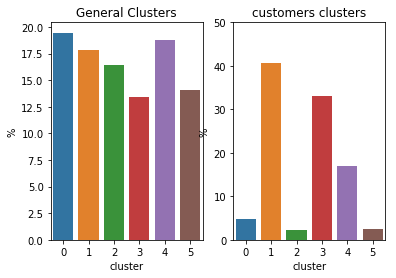

In [66]:
fig, (ax1, ax2) = plt.subplots(1,2, )
sns.barplot(data=general_df, x="cluster", y="%", ax=ax1)
plt.ylim(0, 25)
ax1.set_title('General Clusters')
sns.barplot(data=customers_df, x='cluster', y='%', ax=ax2)
plt.ylim(0,50)
ax2.set_title('customers clusters')

In [80]:
overrepresented_c = pd.Series(data=centroid_1, index=customers_cleaned_imputed.columns)
overrepresented_c

ALTERSKATEGORIE_GROB        3.482683
ANREDE_KZ                   1.319126
CJT_GESAMTTYP               3.072994
FINANZ_MINIMALIST           4.242040
FINANZ_SPARER               1.502836
FINANZ_VORSORGER            4.489609
FINANZ_ANLEGER              1.665419
FINANZ_UNAUFFAELLIGER       1.911858
FINANZ_HAUSBAUER            2.676390
FINANZTYP                   4.276838
GFK_URLAUBERTYP             6.734989
GREEN_AVANTGARDE            0.493753
HEALTH_TYP                  1.974445
LP_FAMILIE_FEIN             5.447685
LP_FAMILIE_GROB             3.293221
LP_STATUS_FEIN              7.219455
LP_STATUS_GROB              3.577027
NATIONALITAET_KZ            1.036659
RETOURTYP_BK_S              3.903145
SEMIO_SOZ                   4.322874
SEMIO_FAM                   3.926838
SEMIO_REL                   3.203102
SEMIO_MAT                   3.461480
SEMIO_VERT                  5.229148
SEMIO_LUST                  5.486339
SEMIO_ERL                   4.846001
SEMIO_KULT                  3.959249
S

In [77]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_2 = pca_20.inverse_transform(model.cluster_centers_[2])

underrepresented_c = pd.Series(data=centroid_1, index=customers_cleaned_imputed.columns)
underrepresented_c

ALTERSKATEGORIE_GROB        3.482683
ANREDE_KZ                   1.319126
CJT_GESAMTTYP               3.072994
FINANZ_MINIMALIST           4.242040
FINANZ_SPARER               1.502836
FINANZ_VORSORGER            4.489609
FINANZ_ANLEGER              1.665419
FINANZ_UNAUFFAELLIGER       1.911858
FINANZ_HAUSBAUER            2.676390
FINANZTYP                   4.276838
GFK_URLAUBERTYP             6.734989
GREEN_AVANTGARDE            0.493753
HEALTH_TYP                  1.974445
LP_FAMILIE_FEIN             5.447685
LP_FAMILIE_GROB             3.293221
LP_STATUS_FEIN              7.219455
LP_STATUS_GROB              3.577027
NATIONALITAET_KZ            1.036659
RETOURTYP_BK_S              3.903145
SEMIO_SOZ                   4.322874
SEMIO_FAM                   3.926838
SEMIO_REL                   3.203102
SEMIO_MAT                   3.461480
SEMIO_VERT                  5.229148
SEMIO_LUST                  5.486339
SEMIO_ERL                   4.846001
SEMIO_KULT                  3.959249
S

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)
From our analysis we pick that cluster 2 are under represented while clauster 1 are over represented. SEMIO_LUST CONCERNING Personality typology is represented with a score of 5.48 while GREEN_AVANTGARDE concerning memebership in environmental sustainability as part of youth is represented at score of 0.49

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.